In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
inspire_path = Path("/home/server/Projects/data/INSPIRE/physionet.org/files/inspire/1.3")
ops_path = inspire_path / "operations.csv"
labs_path = inspire_path / "labs.csv"
vitals_path = inspire_path / "vitals.csv"
ward_vitals_path = inspire_path / "ward_vitals.csv"
combined_path = inspire_path / "combined_data.csv"
combined_cleaned_path = inspire_path / "combined_cleaned_data.csv"
pca_path = inspire_path / "pca_data.csv"


In [4]:
# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'sex', 'emop', 'bmi', 'andur', 
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_albumin', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium']

# Load operations
df = pd.read_csv(ops_path.as_posix())

# find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)
df = df[(df['asa'] < 6)]
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

In [5]:
# Load labs
df_lab = pd.read_csv(labs_path.as_posix())
necessary_vars_labs = df_lab['item_name'].unique().tolist()#['hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium']
print(necessary_vars_labs)
for item_name in necessary_vars_labs:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

df['sex'] = df['sex'] == 'M'

['total_protein', 'sodium', 'potassium', 'platelet', 'glucose', 'wbc', 'alt', 'chloride', 'lymphocyte', 'phosphorus', 'albumin', 'fibrinogen', 'creatinine', 'ptinr', 'total_bilirubin', 'alp', 'aptt', 'calcium', 'bun', 'ast', 'crp', 'hb', 'hct', 'seg', 'ica', 'ph', 'paco2', 'pao2', 'hco3', 'sao2', 'lacate', 'ckmb', 'troponin_i', 'ck', 'hba1c', 'be', 'troponin_t', 'd_dimer']


In [6]:
# Load vitals
df_vitals = pd.read_csv(vitals_path.as_posix())
necessary_vars_vitals = df_vitals['item_name'].unique().tolist()#['hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium']
print(necessary_vars_vitals)
for item_name in necessary_vars_vitals:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_vitals.loc[df_vitals['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'early_op_{item_name}'}, inplace=True)


['minvol', 'vt', 'rr', 'pip', 'nibp_sbp', 'nibp_dbp', 'nibp_mbp', 'o2', 'hs', 'hr', 'spo2', 'air', 'etco2', 'bt', 'uo', 'peep', 'fio2', 'bis', 'ebl', 'ppfi', 'rfti', 'hes', 'ns', 'etsevo', 'etgas', 'art_sbp', 'art_dbp', 'art_mbp', 'cvp', 'pap_sbp', 'pap_dbp', 'pap_mbp', 'ntgi', 'nepi', 'ci', 'rbc', 'dobui', 'ffp', 'pc', 'cryo', 'n2o', 'psa', 'ppf', 'etdes', 'hns', 'alb20', 'mlni', 'pepi', 'dopai', 'mdz', 'ftn', 'd5w', 'alb5', 'epii', 'cbro2', 'd10w', 'ds', 'pplat', 'pmean', 'd50w', 'sft', 'phe', 'eph', 'cpat', 'vaso', 'epi', 'pheresis', 'etiso', 'aft', 'svi', 'stii', 'stv5', 'stiii', 'sti']


In [7]:
# Load ward vitals
df_ward_vitals = pd.read_csv(ward_vitals_path.as_posix())
necessary_vars_ward_vitals = df_ward_vitals['item_name'].unique().tolist()#['hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium']
print(necessary_vars_vitals)
for item_name in necessary_vars_ward_vitals:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_ward_vitals.loc[df_ward_vitals['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'pre_op_{item_name}'}, inplace=True)

['minvol', 'vt', 'rr', 'pip', 'nibp_sbp', 'nibp_dbp', 'nibp_mbp', 'o2', 'hs', 'hr', 'spo2', 'air', 'etco2', 'bt', 'uo', 'peep', 'fio2', 'bis', 'ebl', 'ppfi', 'rfti', 'hes', 'ns', 'etsevo', 'etgas', 'art_sbp', 'art_dbp', 'art_mbp', 'cvp', 'pap_sbp', 'pap_dbp', 'pap_mbp', 'ntgi', 'nepi', 'ci', 'rbc', 'dobui', 'ffp', 'pc', 'cryo', 'n2o', 'psa', 'ppf', 'etdes', 'hns', 'alb20', 'mlni', 'pepi', 'dopai', 'mdz', 'ftn', 'd5w', 'alb5', 'epii', 'cbro2', 'd10w', 'ds', 'pplat', 'pmean', 'd50w', 'sft', 'phe', 'eph', 'cpat', 'vaso', 'epi', 'pheresis', 'etiso', 'aft', 'svi', 'stii', 'stv5', 'stiii', 'sti']


In [8]:
# Write the DataFrame to a CSV file

df.to_csv(combined_path.as_posix(), index=False)

In [9]:
# pd.set_option('display.max_columns', None)  # Display all columns
# pd.set_option('display.width', None)   
# print(df.head(1))

# Find the intersection of subject_id values in both DataFrames
subject_id_intersection = list(set(df['subject_id']).intersection(set(df_vitals['subject_id'])))

# Print the list of intersecting subject_id values
print(subject_id_intersection)

print(len(subject_id_intersection))

[153616384, 164888580, 137625612, 109314061, 112721933, 192413713, 120324114, 116916250, 177471514, 133955612, 180879392, 160432162, 148635682, 166199333, 196345894, 147587111, 149422120, 182976553, 197132331, 156500013, 197656633, 103809083, 125304891, 129499202, 136052803, 118227014, 106954822, 133693514, 112984143, 154140752, 129761361, 105644112, 167772244, 112459861, 106430551, 103022683, 170393692, 112459871, 137887842, 143917154, 100401252, 138412132, 128450661, 123207790, 193200242, 175898742, 186384514, 133431432, 194248842, 169345164, 173015181, 149946510, 104857744, 177209491, 112722071, 128975004, 142082204, 176947361, 176423080, 150208684, 138150060, 184549550, 112459952, 137625780, 197918902, 142082231, 113246393, 188481722, 150470844, 125305020, 195559614, 157548732, 188219584, 197394621, 150470850, 172753091, 128975050, 141557964, 125829324, 194511062, 142868700, 147325150, 196608222, 122683621, 182190312, 110100713, 149422314, 134742260, 158335220, 129237241, 148373754

In [10]:
# Filter the DataFrame for the specific subject_id
subject_row = df[df['subject_id'] == 120324114]

# Print the row
print(subject_row)

           op_id  subject_id    hadm_id  case_id  opdate  age   sex  weight  \
46519  456059626   120324114  285148589      NaN    1440   65  True    75.0   

       height   race  ...  pre_op_nibp_mbp  pre_op_crrt pre_op_ecmo pre_op_uo  \
46519   170.0  Asian  ...              NaN          NaN         NaN       NaN   

      pre_op_vent  pre_op_gcs_e  pre_op_gcs_m  pre_op_gcs_v  pre_op_fio2  \
46519         NaN           NaN           NaN           NaN          NaN   

       pre_op_iabp  
46519          NaN  

[1 rows x 234 columns]


In [11]:
df

,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,...,pre_op_nibp_mbp,pre_op_crrt,pre_op_ecmo,pre_op_uo,pre_op_vent,pre_op_gcs_e,pre_op_gcs_m,pre_op_gcs_v,pre_op_fio2,pre_op_iabp
0,403543518,164935053,251633071,NaN,0,45,True,65.0,180.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,429493668,196269490,269094492,NaN,0,55,False,60.0,160.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,490288058,143981214,268056914,1211.0,0,75,True,NaN,NaN,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,453052475,140696052,251635295,NaN,0,75,False,50.0,155.0,Asian,...,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,474826299,122791000,258548446,NaN,0,50,False,50.0,160.0,Asian,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,NaN,5031360,50,True,75.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97285,409353759,157622470,278769283,NaN,5064480,65,True,60.0,160.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97286,417368839,196070660,228888251,NaN,5065920,70,True,65.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97287,434627934,106196053,264484804,NaN,5078880,65,True,70.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_combined = pd.read_csv(combined_path.as_posix())
df_combined

,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,...,pre_op_nibp_mbp,pre_op_crrt,pre_op_ecmo,pre_op_uo,pre_op_vent,pre_op_gcs_e,pre_op_gcs_m,pre_op_gcs_v,pre_op_fio2,pre_op_iabp
0,403543518,164935053,251633071,NaN,0,45,True,65.0,180.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,429493668,196269490,269094492,NaN,0,55,False,60.0,160.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,490288058,143981214,268056914,1211.0,0,75,True,NaN,NaN,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,453052475,140696052,251635295,NaN,0,75,False,50.0,155.0,Asian,...,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,474826299,122791000,258548446,NaN,0,50,False,50.0,160.0,Asian,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,NaN,5031360,50,True,75.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97285,409353759,157622470,278769283,NaN,5064480,65,True,60.0,160.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97286,417368839,196070660,228888251,NaN,5065920,70,True,65.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97287,434627934,106196053,264484804,NaN,5078880,65,True,70.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Calculate the percentage of NaN values in each column
nan_percentage = df_combined.isna().mean() * 100

# Create a DataFrame from the NaN percentage series for better display
nan_percentage_df = nan_percentage.to_frame(name='NaN Percentage').reset_index()
nan_percentage_df.columns = ['Column', 'NaN Percentage']

pd.set_option('display.max_columns', 10)  # Display all columns
pd.set_option('display.width', None) 
pd.set_option('display.max_rows', 10)

nan_percentage_df

,Column,NaN Percentage
0,op_id,0.000000
1,subject_id,0.000000
2,hadm_id,0.000000
3,case_id,83.335218
4,opdate,0.000000
...,...,...
229,pre_op_gcs_e,98.629855
230,pre_op_gcs_m,98.629855
231,pre_op_gcs_v,98.788147
232,pre_op_fio2,98.925881


In [14]:
columns_to_drop = nan_percentage_df[nan_percentage_df['NaN Percentage'] > 70]['Column']
# Drop these columns from df_combined
df_combined = df_combined.drop(columns=columns_to_drop)

# Display the updated DataFrame
df_combined


,op_id,subject_id,hadm_id,opdate,age,...,pre_op_nibp_sbp,pre_op_hr,pre_op_nibp_dbp,pre_op_bt,pre_op_rr
0,403543518,164935053,251633071,0,45,...,113.0,96.0,67.0,37.3,16.0
1,429493668,196269490,269094492,0,55,...,150.0,68.0,94.0,36.3,19.0
2,490288058,143981214,268056914,0,75,...,136.0,88.0,62.0,36.0,17.0
3,453052475,140696052,251635295,0,75,...,136.0,56.0,60.0,36.4,18.0
4,474826299,122791000,258548446,0,50,...,144.0,96.0,64.0,36.3,18.0
...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,5031360,50,...,108.0,66.0,67.0,36.3,17.0
97285,409353759,157622470,278769283,5064480,65,...,110.0,64.0,72.0,36.4,17.0
97286,417368839,196070660,228888251,5065920,70,...,150.0,56.0,82.0,36.0,19.0
97287,434627934,106196053,264484804,5078880,65,...,169.0,120.0,100.0,36.3,19.0


In [15]:
df_combined

,op_id,subject_id,hadm_id,opdate,age,...,pre_op_nibp_sbp,pre_op_hr,pre_op_nibp_dbp,pre_op_bt,pre_op_rr
0,403543518,164935053,251633071,0,45,...,113.0,96.0,67.0,37.3,16.0
1,429493668,196269490,269094492,0,55,...,150.0,68.0,94.0,36.3,19.0
2,490288058,143981214,268056914,0,75,...,136.0,88.0,62.0,36.0,17.0
3,453052475,140696052,251635295,0,75,...,136.0,56.0,60.0,36.4,18.0
4,474826299,122791000,258548446,0,50,...,144.0,96.0,64.0,36.3,18.0
...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,5031360,50,...,108.0,66.0,67.0,36.3,17.0
97285,409353759,157622470,278769283,5064480,65,...,110.0,64.0,72.0,36.4,17.0
97286,417368839,196070660,228888251,5065920,70,...,150.0,56.0,82.0,36.0,19.0
97287,434627934,106196053,264484804,5078880,65,...,169.0,120.0,100.0,36.3,19.0


In [16]:
# Write the DataFrame to a CSV file

df_combined.to_csv(combined_cleaned_path.as_posix(), index=False)

In [17]:
df_combined_cleaned = pd.read_csv(combined_cleaned_path.as_posix())

In [18]:
df_combined_cleaned.columns

Index(['op_id', 'subject_id', 'hadm_id', 'opdate', 'age', 'sex', 'weight',
       'height', 'race', 'asa', 'emop', 'department', 'antype', 'icd10_pcs',
       'orin_time', 'orout_time', 'opstart_time', 'opend_time',
       'admission_time', 'discharge_time', 'anstart_time', 'anend_time',
       'inhosp_death_30day', 'andur', 'bmi', 'preop_total_protein',
       'preop_sodium', 'preop_potassium', 'preop_platelet', 'preop_glucose',
       'preop_wbc', 'preop_alt', 'preop_chloride', 'preop_lymphocyte',
       'preop_phosphorus', 'preop_albumin', 'preop_fibrinogen',
       'preop_creatinine', 'preop_ptinr', 'preop_total_bilirubin', 'preop_alp',
       'preop_aptt', 'preop_calcium', 'preop_bun', 'preop_ast', 'preop_crp',
       'preop_hb', 'preop_hct', 'preop_seg', 'op_id_.4', 'early_op_nibp_sbp',
       'op_id_.5', 'early_op_nibp_dbp', 'op_id_.6', 'early_op_nibp_mbp',
       'op_id_.10', 'early_op_spo2', 'op_id_.12', 'early_op_etco2',
       'op_id_.16', 'early_op_fio2', 'pre_op_spo2', 'pr

In [19]:
# Calculate the threshold for non-NaN values (50% of total columns)
threshold = int(df_combined_cleaned.shape[1] * 0.5)

# Drop rows with more than 50% NaN values
df_combined_cleaned = df_combined_cleaned.dropna(thresh=threshold)

# Display the cleaned DataFrame
df_combined_cleaned

,op_id,subject_id,hadm_id,opdate,age,...,pre_op_nibp_sbp,pre_op_hr,pre_op_nibp_dbp,pre_op_bt,pre_op_rr
0,403543518,164935053,251633071,0,45,...,113.0,96.0,67.0,37.3,16.0
1,429493668,196269490,269094492,0,55,...,150.0,68.0,94.0,36.3,19.0
2,490288058,143981214,268056914,0,75,...,136.0,88.0,62.0,36.0,17.0
3,453052475,140696052,251635295,0,75,...,136.0,56.0,60.0,36.4,18.0
4,474826299,122791000,258548446,0,50,...,144.0,96.0,64.0,36.3,18.0
...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,5031360,50,...,108.0,66.0,67.0,36.3,17.0
97285,409353759,157622470,278769283,5064480,65,...,110.0,64.0,72.0,36.4,17.0
97286,417368839,196070660,228888251,5065920,70,...,150.0,56.0,82.0,36.0,19.0
97287,434627934,106196053,264484804,5078880,65,...,169.0,120.0,100.0,36.3,19.0


In [20]:
df_combined_cleaned.to_csv(combined_cleaned_path.as_posix(), index=False)

In [ ]:
df_combined_cleaned = pd.read_csv(combined_cleaned_path.as_posix())
# List of columns to drop
columns_to_drop = ['op_id', 'subject_id', 'hadm_id', 'opdate', 'sex', 'race', 'asa', 'emop', 'department', 'antype', 'icd10_pcs', 'op_id_.4', 'op_id_.5', 'op_id_.6', 'op_id_.10', 'op_id_.12', 'op_id_.16', 'orin_time', 'orout_time', 'opstart_time', 'opend_time', 'admission_time', 'discharge_time', 'anstart_time', 'anend_time', 'inhosp_death_30day'] 
# Drop the columns from the DataFrame
df_combined_cleaned = df_combined_cleaned.drop(columns=columns_to_drop)

# Set the threshold for Z-scores
threshold = 3

# Calculate Z-scores for each column
z_scores = df_combined_cleaned.apply(zscore, args=(0,0,'omit'))

# Set values with Z-score beyond the threshold to NaN
print(df_combined_cleaned.isna().sum().sum(), df_combined_cleaned.notna().sum().sum())
df_outliers_as_nans = df_combined_cleaned.mask(z_scores.abs() > threshold)
print(df_outliers_as_nans.isna().sum().sum(), df_outliers_as_nans.notna().sum().sum())

672825 3223405
706982 3189248


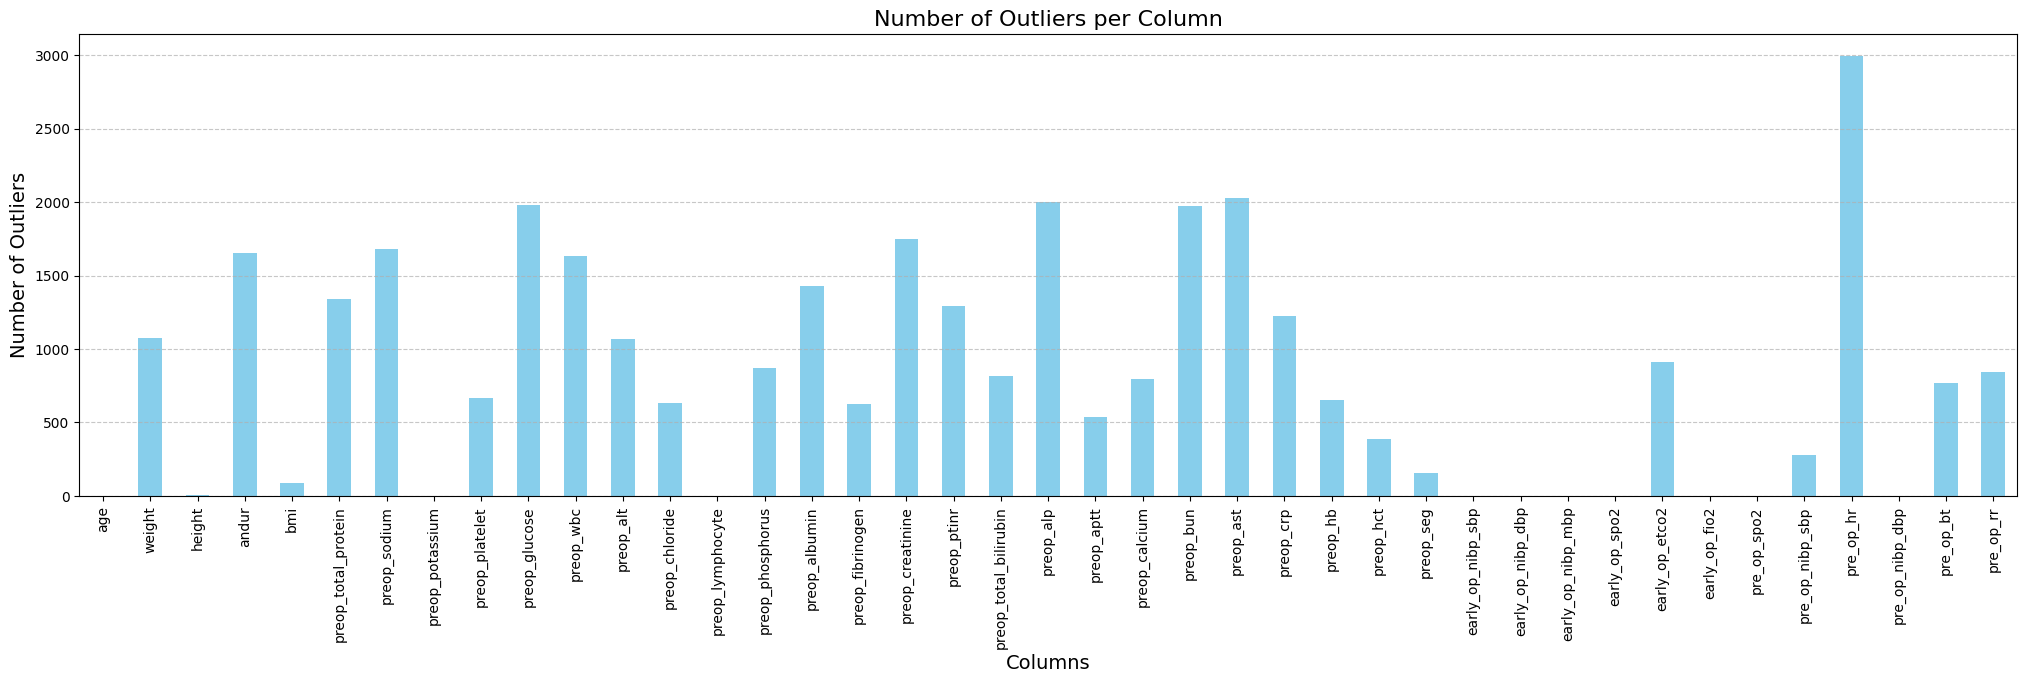

In [81]:
# outlier_counts = outlier_counts.sort_values(ascending=False)
# Plot the columns with the most outliers
outlier_counts = (z_scores.abs() > 3).sum()
plt.figure(figsize=(25, 6))
outlier_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Outliers per Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of Outliers', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

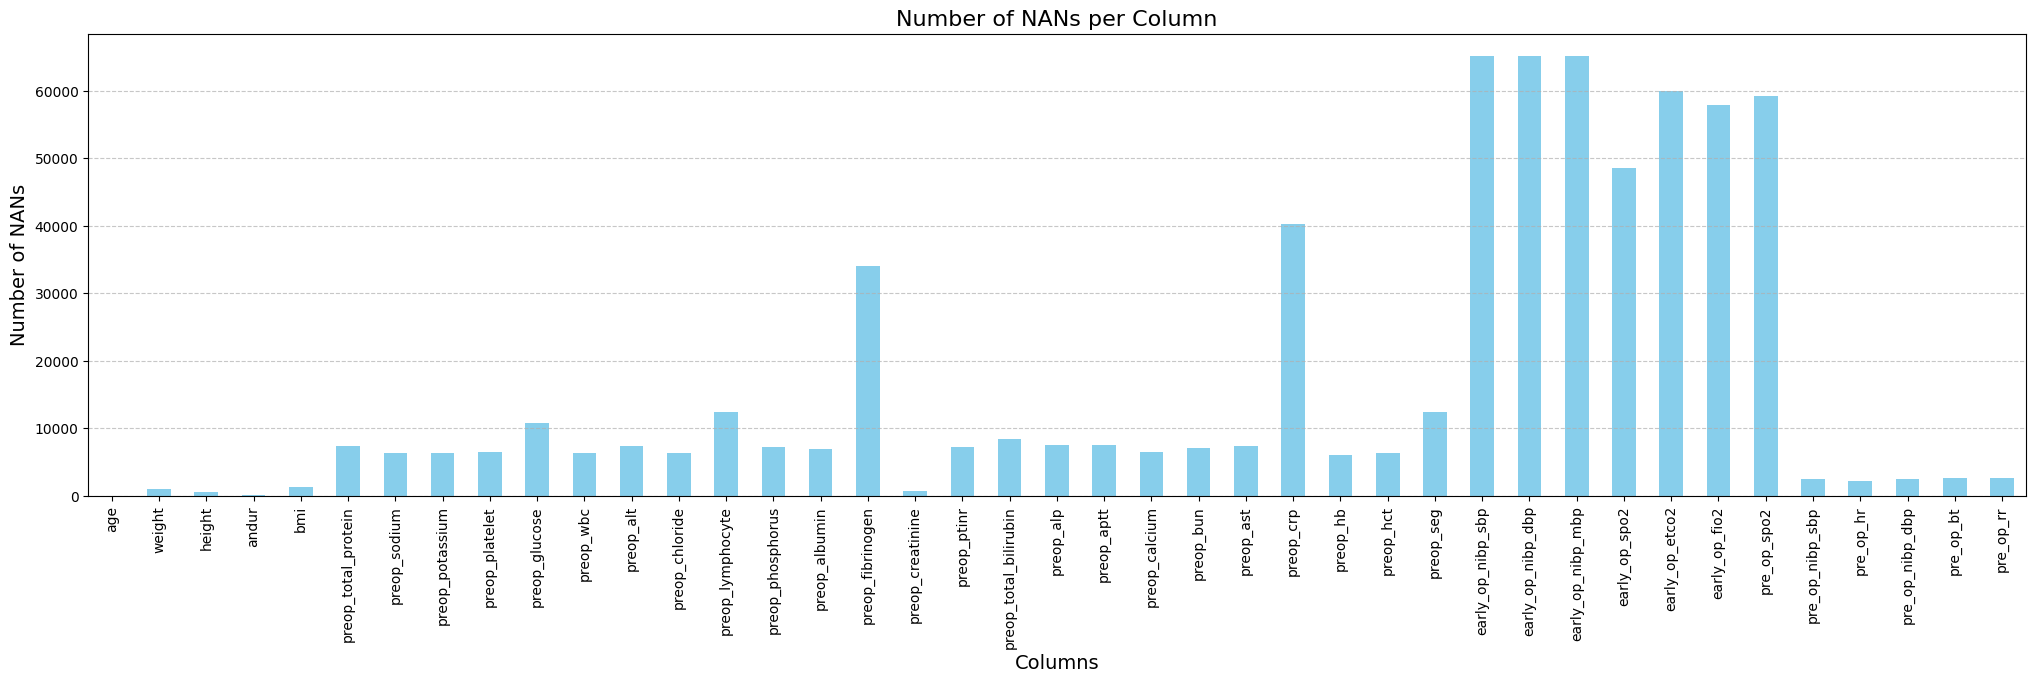

In [83]:
nan_counts = df_combined_cleaned.isna().sum()
plt.figure(figsize=(25, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Number of NANs per Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of NANs', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [78]:
# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=20, verbose=1, random_state=0)

# Apply the imputer to df_combined_cleaned
# Note: IterativeImputer returns a NumPy array, so we convert it back to a DataFrame
df_combined_imputed = pd.DataFrame(imputer.fit_transform(df_outliers_as_nans), 
                                   columns=df_outliers_as_nans.columns)

[IterativeImputer] Completing matrix with shape (95030, 41)
[IterativeImputer] Change: 360.0382066954393, scaled tolerance: 0.551 
[IterativeImputer] Change: 107.918719193752, scaled tolerance: 0.551 
[IterativeImputer] Change: 41.52895660143487, scaled tolerance: 0.551 
[IterativeImputer] Change: 37.5580766145349, scaled tolerance: 0.551 
[IterativeImputer] Change: 37.858428577707386, scaled tolerance: 0.551 
[IterativeImputer] Change: 36.699336171497876, scaled tolerance: 0.551 
[IterativeImputer] Change: 40.82888529790782, scaled tolerance: 0.551 
[IterativeImputer] Change: 42.322539955066816, scaled tolerance: 0.551 
[IterativeImputer] Change: 41.214791778460416, scaled tolerance: 0.551 
[IterativeImputer] Change: 36.76899444928414, scaled tolerance: 0.551 
[IterativeImputer] Change: 30.210750006320687, scaled tolerance: 0.551 
[IterativeImputer] Change: 23.25784943126895, scaled tolerance: 0.551 
[IterativeImputer] Change: 17.46137543312217, scaled tolerance: 0.551 
[IterativeImpu

/home/server/Projects/VitalDB-Dimensionality-Reduction/.venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


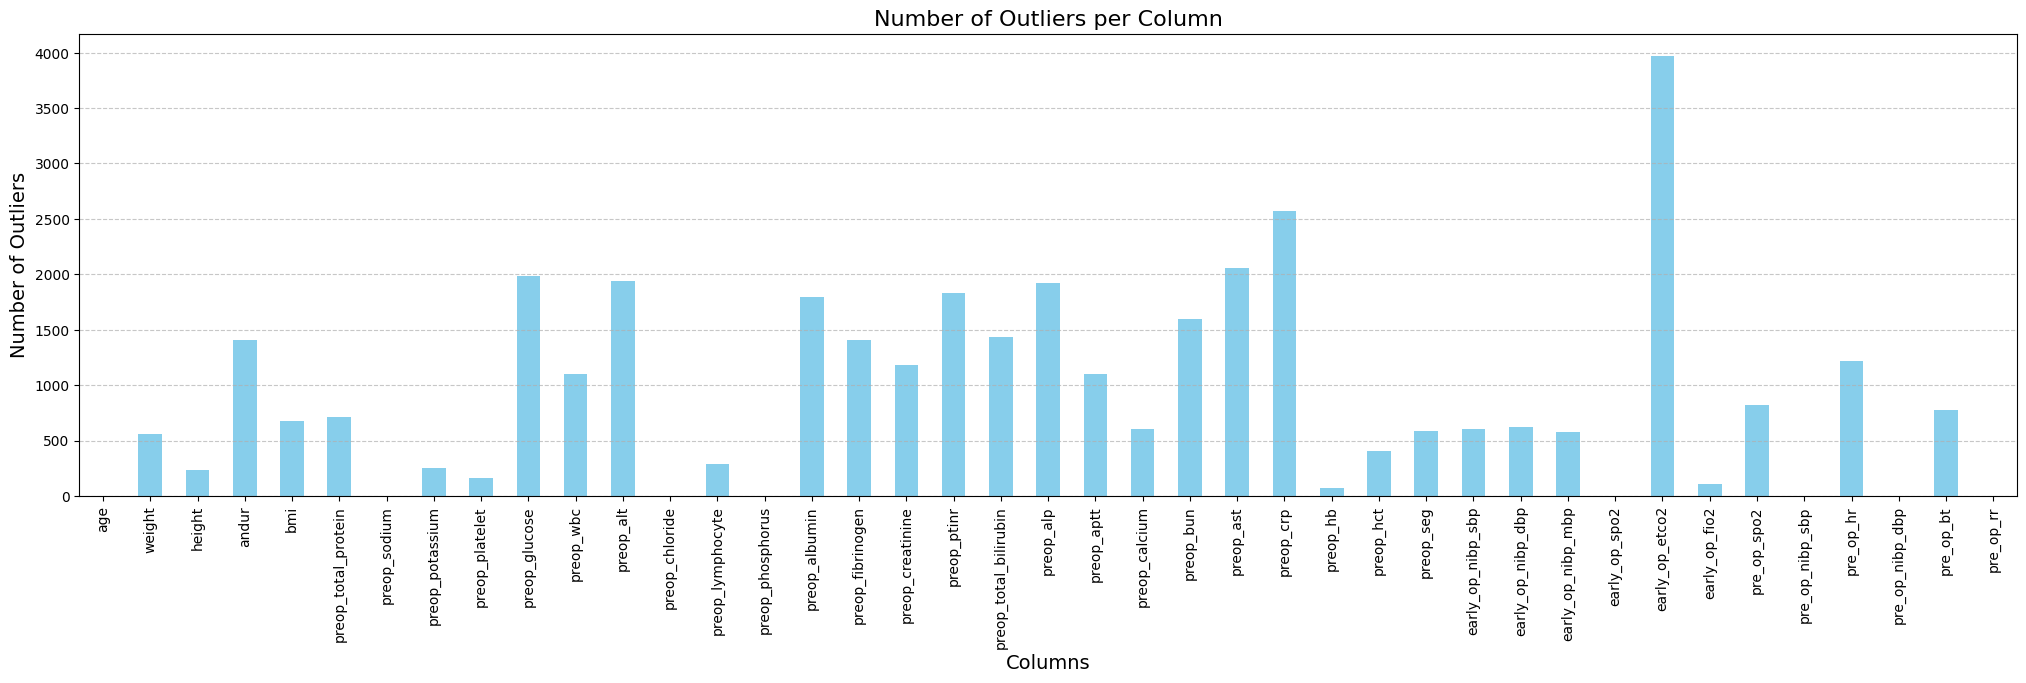

In [79]:
imp_z_scores = df_combined_imputed.apply(zscore)
imp_outlier_count = (imp_z_scores.abs() > 3).sum()
plt.figure(figsize=(25, 6))
imp_outlier_count.plot(kind='bar', color='skyblue')
plt.title('Number of Outliers per Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of Outliers', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [84]:
df_combined_imputed.to_csv(pca_path.as_posix(), index=False)

Explained Variance Ratios for each Principal Component:
PC1: 0.1236 (12.36%)
PC2: 0.1031 (10.31%)
PC3: 0.0665 (6.65%)
PC4: 0.0532 (5.32%)
PC5: 0.0478 (4.78%)
PC6: 0.0429 (4.29%)
PC7: 0.0399 (3.99%)
PC8: 0.0384 (3.84%)
PC9: 0.0326 (3.26%)
PC10: 0.0312 (3.12%)
PC11: 0.0294 (2.94%)
PC12: 0.0280 (2.80%)
PC13: 0.0256 (2.56%)
PC14: 0.0237 (2.37%)
PC15: 0.0225 (2.25%)
PC16: 0.0211 (2.11%)
PC17: 0.0203 (2.03%)
PC18: 0.0197 (1.97%)
PC19: 0.0192 (1.92%)
PC20: 0.0184 (1.84%)
PC21: 0.0181 (1.81%)
PC22: 0.0179 (1.79%)
PC23: 0.0166 (1.66%)
PC24: 0.0157 (1.57%)
PC25: 0.0147 (1.47%)
PC26: 0.0142 (1.42%)
PC27: 0.0133 (1.33%)
PC28: 0.0114 (1.14%)
PC29: 0.0108 (1.08%)
PC30: 0.0103 (1.03%)

Total Variance Captured by All Components: 0.9505 (95.05%)

Cumulative Explained Variance:
PC1 to PC1: 0.1236 (12.36%)
PC1 to PC2: 0.2268 (22.68%)
PC1 to PC3: 0.2933 (29.33%)
PC1 to PC4: 0.3465 (34.65%)
PC1 to PC5: 0.3943 (39.43%)
PC1 to PC6: 0.4372 (43.72%)
PC1 to PC7: 0.4771 (47.71%)
PC1 to PC8: 0.5156 (51.56%)
PC1 t

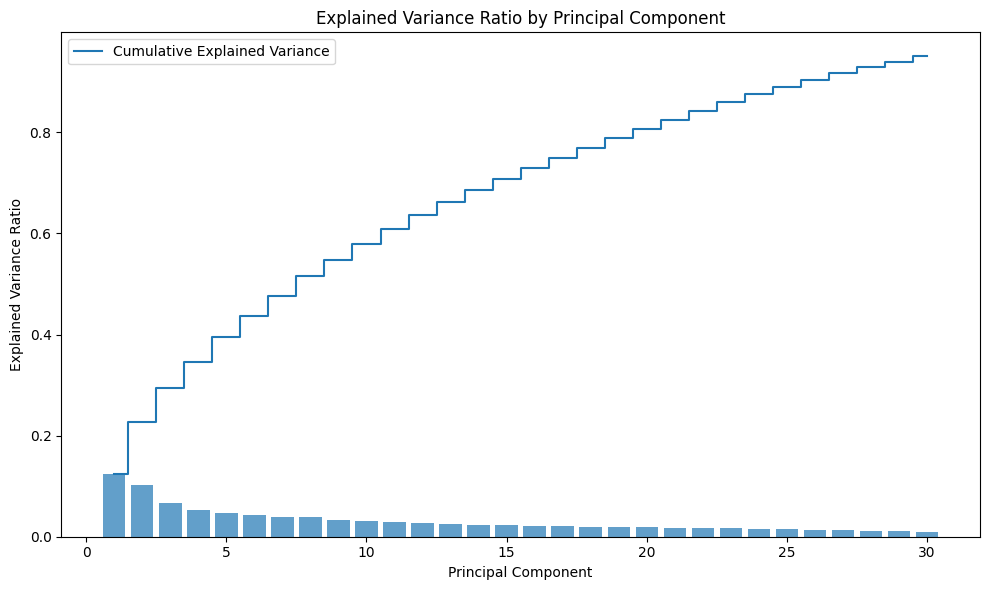

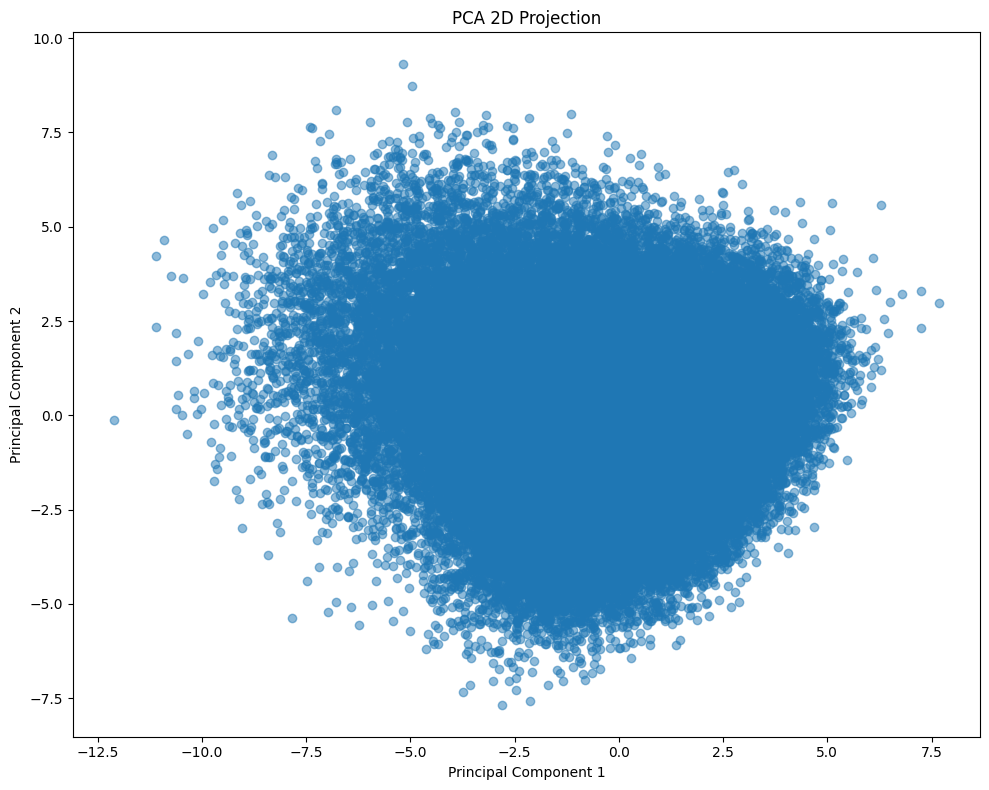

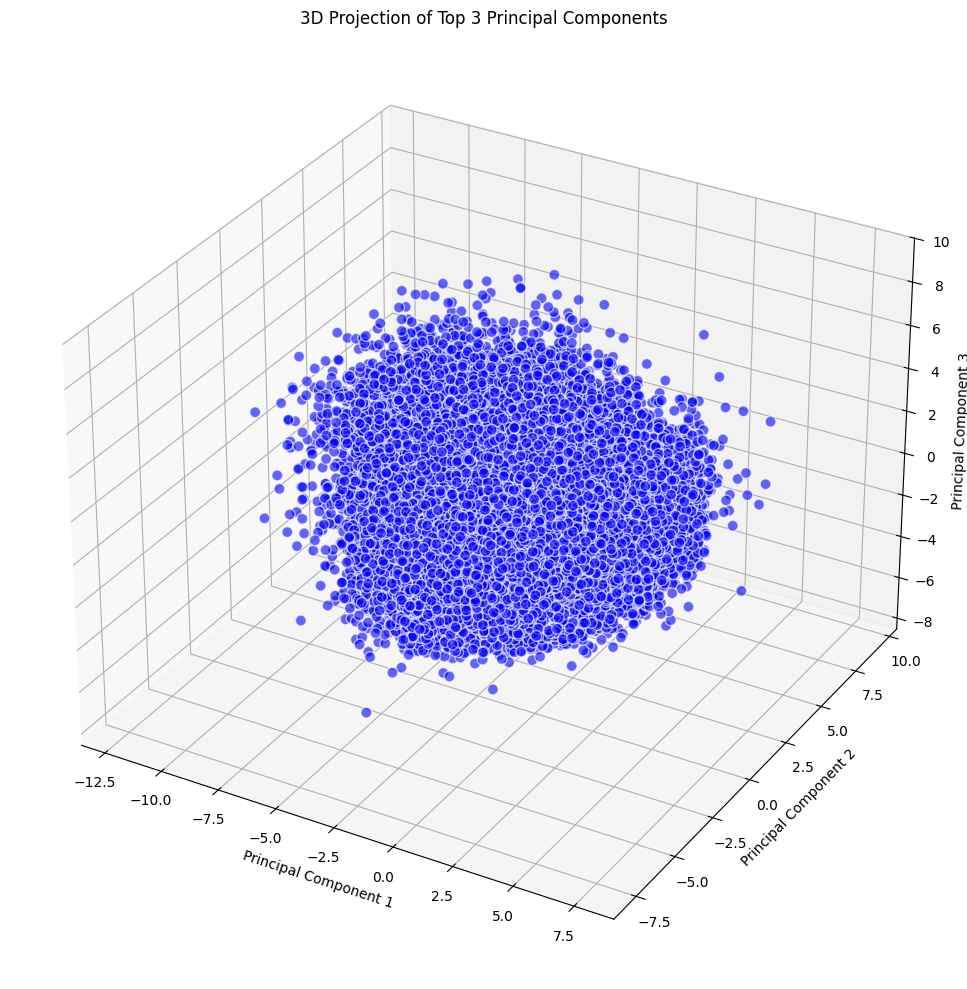

/tmp/ipykernel_6639/3367387214.py:115: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pc1, pc2, pc3, cmap='viridis', alpha=0.6, s=60, edgecolors='w')


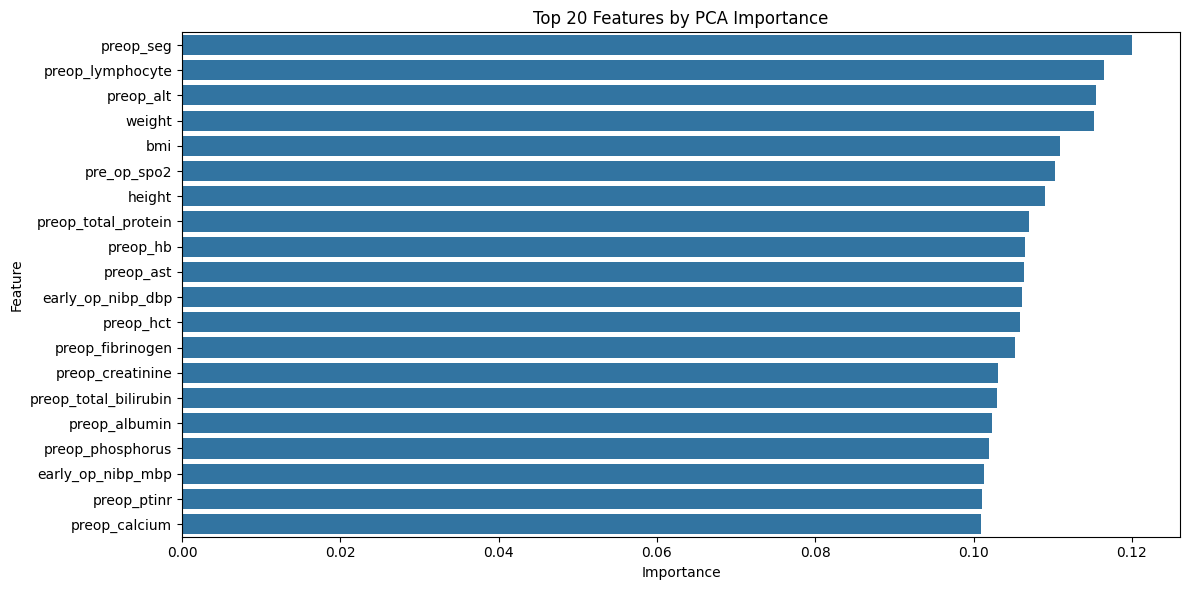

,Feature,Importance
0,preop_seg,0.120070
1,preop_lymphocyte,0.116438
2,preop_alt,0.115406
3,weight,0.115262
4,bmi,0.110926
5,pre_op_spo2,0.110253
6,height,0.109058
7,preop_total_protein,0.107015
8,preop_hb,0.106530
9,preop_ast,0.106352


In [90]:
# Load the data
df_combined_imputed = pd.read_csv(pca_path.as_posix())

# Standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_combined_imputed), 
                                   columns=df_combined_imputed.columns)

# Set the number of components
n_components = 30

# Initialize and fit PCA
pca = PCA(n_components=n_components)
pca.fit(df_scaled)

# Identify the top 5 components based on explained variance
explained_variance_ratio = pca.explained_variance_ratio_
top_5_indices = explained_variance_ratio.argsort()[::-1][:5]  # Get indices of the top 5 components
top_20_indices = explained_variance_ratio.argsort()[::-1][:20]


# Display the explained variance ratio for each component
print("Explained Variance Ratios for each Principal Component:")
for i, var_ratio in enumerate(explained_variance_ratio, start=1):
    print(f"PC{i}: {var_ratio:.4f} ({var_ratio * 100:.2f}%)")

# Calculate and print the total variance captured by all components
total_variance = explained_variance_ratio.sum()
print(f"\nTotal Variance Captured by All Components: {total_variance:.4f} ({total_variance * 100:.2f}%)")

# Display cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("\nCumulative Explained Variance:")
for i, cum_var in enumerate(cumulative_variance, start=1):
    print(f"PC1 to PC{i}: {cum_var:.4f} ({cum_var * 100:.2f}%)")

# Create a DataFrame for loadings of only the top 5 components
loadings = pd.DataFrame(
    pca.components_.T[:, top_5_indices],  # Select only the top 5 components
    columns=[f'PC{i+1}' for i in top_5_indices],
    index=df_scaled.columns  # Use original feature names as index
)

# 11/16/2024 New Change

# Display the loadings to see the contributions of each covariate to the top components
print("\nPCA Loadings (Contribution of each feature to the top 5 highest-variance components):")
print(loadings)

# Create a DataFrame for loadings of only the top 20 components
t20_loadings = pd.DataFrame(
    pca.components_.T[:, top_20_indices],  # Select only the top 20 components
    columns=[f'PC{i+1}' for i in top_20_indices],
    index=df_scaled.columns  # Use original feature names as index
)

# Extract the explained variance ratios for the top 20 PCs
top_20_explained_variance_ratio = explained_variance_ratio[top_20_indices]

# Adjust the loadings by multiplying with the explained variance ratios
adjusted_loadings = t20_loadings * top_20_explained_variance_ratio

# Calculate the importance of each feature by summing the absolute adjusted loadings
pca_importance_scores = adjusted_loadings.abs().sum(axis=1).sort_values(ascending=False)
print("\nCovariate Importance Scores based on the Top 20 Highest-Variance Components in PCA:")
print(pca_importance_scores)

# Plot the explained variance ratio for each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plot the top 2 principal components
pca_transformed = pca.transform(df_scaled)
plt.figure(figsize=(10, 8))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA 2D Projection')
plt.tight_layout()
plt.show()

# Extract the scores for the top 3 principal components
pc1 = pca_transformed[:, 0]
pc2 = pca_transformed[:, 1]
pc3 = pca_transformed[:, 2]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(pc1, pc2, pc3, c='blue', alpha=0.6, s=60, edgecolors='w')

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Projection of Top 3 Principal Components')

# Show plot
plt.tight_layout()
plt.show()


# Assuming you have a 'labels' array corresponding to your data points
ax.scatter(pc1, pc2, pc3, cmap='viridis', alpha=0.6, s=60, edgecolors='w')

# Create a DataFrame for the importance scores
pca_importance_df = pca_importance_scores.reset_index()
pca_importance_df.columns = ['Feature', 'Importance']

# Plot top 20 features by PCA importance
plt.figure(figsize=(12, 6))
sns.barplot(data=pca_importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Features by PCA Importance')
plt.tight_layout()
plt.show()

# Display the PCA importance DataFrame
pca_importance_df

In [ ]:
df_combined_imputed
df = pd.read_csv(ops_path.as_posix())
df["inhosp_death_time"]
df["postop_los"] = df["discharge_time"] - df["opend_time"]
df[["op_id", "postop_los"]]
df["postop_los"].mean()

In [11]:
# Load and standardize the data
df_combined_imputed = pd.read_csv(pca_path.as_posix())
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_combined_imputed), 
                         columns=df_combined_imputed.columns)

# Set parameters
n_components = 10

# Initialize and fit UMAP
reducer = UMAP(n_components=n_components,
               random_state=None, #None allows for reproducibility, set a random state for reproducability,
               n_jobs=-1, 
               n_neighbors=30,
               min_dist=0.1)
umap_embedding = reducer.fit_transform(df_scaled)

In [14]:
# Calculate feature importances for each UMAP component
umap_feature_importances = []
for i in range(n_components):
    component_importances = [abs(np.corrcoef(df_scaled[feature], umap_embedding[:, i])[0, 1]) 
                             for feature in df_scaled.columns]
    umap_feature_importances.append(component_importances)

# Convert to DataFrame for better readability
umap_feature_importances_df = pd.DataFrame(umap_feature_importances, columns=df_scaled.columns)

# Print the top features for each UMAP component
for i in range(n_components):
    print(f"Top features for UMAP component {i+1}:")
    top_features = umap_feature_importances_df.iloc[i].sort_values(ascending=False).head(5)
    print(top_features)
    print("\n")

Top features for UMAP component 1:
height       0.400257
bmi          0.332297
weight       0.036766
preop_hct    0.032881
preop_hb     0.032773
Name: 0, dtype: float64


Top features for UMAP component 2:
preop_hb          0.535767
preop_hct         0.524415
early_op_etco2    0.477265
preop_albumin     0.432716
preop_crp         0.387239
Name: 1, dtype: float64


Top features for UMAP component 3:
preop_albumin     0.517382
preop_hb          0.458437
preop_hct         0.453258
early_op_spo2     0.431982
early_op_etco2    0.398755
Name: 2, dtype: float64


Top features for UMAP component 4:
early_op_nibp_mbp    0.694370
early_op_nibp_dbp    0.653877
early_op_nibp_sbp    0.634488
pre_op_nibp_sbp      0.597173
pre_op_nibp_dbp      0.561196
Name: 3, dtype: float64


Top features for UMAP component 5:
pre_op_nibp_dbp      0.417764
pre_op_nibp_sbp      0.416269
early_op_nibp_sbp    0.405548
early_op_nibp_mbp    0.393452
pre_op_rr            0.368854
Name: 4, dtype: float64


Top features fo

UMAP Feature Importance Scores:
                  Feature  Importance
26               preop_hb    0.362278
27              preop_hct    0.355988
15          preop_albumin    0.315145
31      early_op_nibp_mbp    0.301832
29      early_op_nibp_sbp    0.285022
30      early_op_nibp_dbp    0.275440
1                  weight    0.271507
5     preop_total_protein    0.253969
33         early_op_etco2    0.249307
2                  height    0.245420
36        pre_op_nibp_sbp    0.238289
38        pre_op_nibp_dbp    0.233500
22          preop_calcium    0.232652
17       preop_creatinine    0.221956
40              pre_op_rr    0.221554
25              preop_crp    0.214817
11              preop_alt    0.203358
0                     age    0.193514
13       preop_lymphocyte    0.191850
16       preop_fibrinogen    0.189687
4                     bmi    0.182452
28              preop_seg    0.173063
23              preop_bun    0.153156
32          early_op_spo2    0.151153
35            pre_

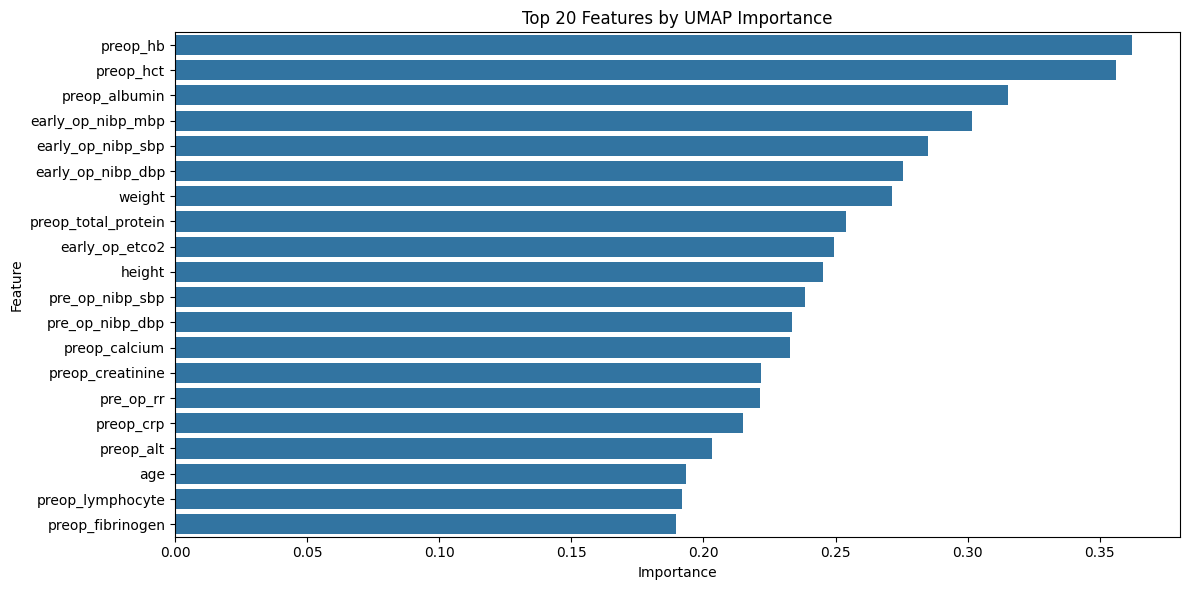

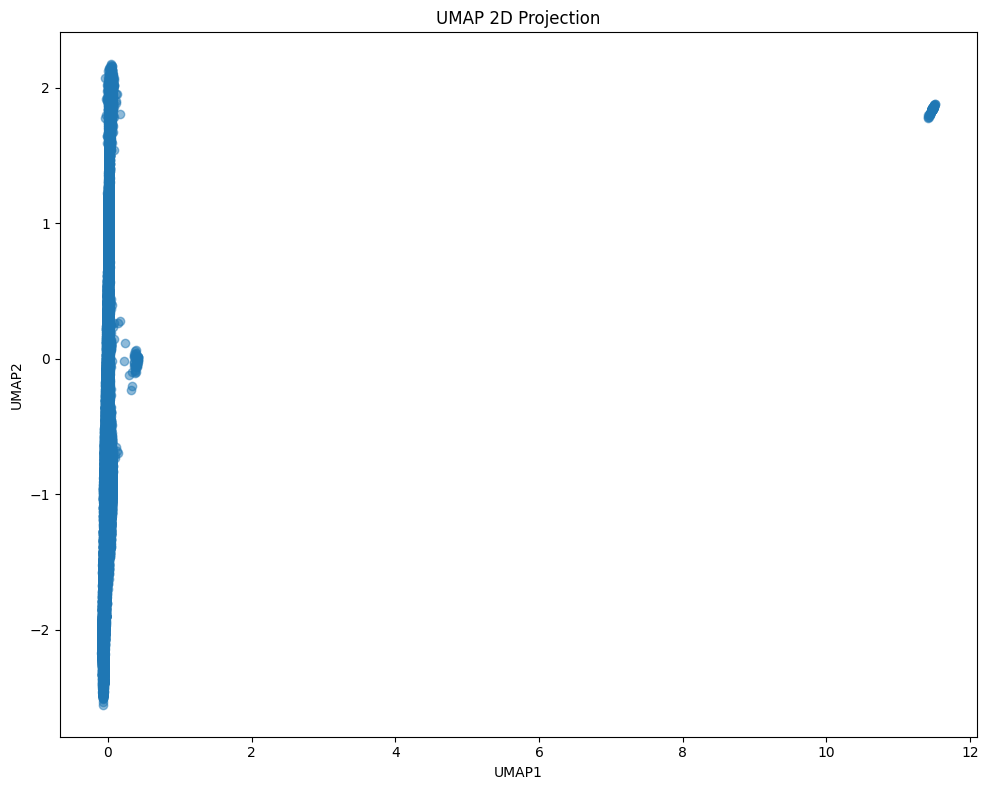

,Feature,Importance
26,preop_hb,0.362278
27,preop_hct,0.355988
15,preop_albumin,0.315145
31,early_op_nibp_mbp,0.301832
29,early_op_nibp_sbp,0.285022
30,early_op_nibp_dbp,0.275440
1,weight,0.271507
5,preop_total_protein,0.253969
33,early_op_etco2,0.249307
2,height,0.245420


In [15]:
# Calculate feature importance using correlation with UMAP components
feature_importances = []
for i in range(n_components):
    correlations = [abs(np.corrcoef(df_scaled[feature], umap_embedding[:, i])[0, 1]) 
                   for feature in df_scaled.columns]
    feature_importances.append(correlations)

# Calculate overall importance scores
umap_importance_scores = np.mean(np.abs(feature_importances), axis=0)
umap_importance_df = pd.DataFrame({
    'Feature': df_scaled.columns,
    'Importance': umap_importance_scores
}).sort_values('Importance', ascending=False)

# Display results
print("UMAP Feature Importance Scores:")
print(umap_importance_df)

# Plot top 20 features by UMAP importance
plt.figure(figsize=(12, 6))
sns.barplot(data=umap_importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Features by UMAP Importance')
plt.tight_layout()
plt.show()

# Plot 2D projection
plt.figure(figsize=(10, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.5)
plt.title('UMAP 2D Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

# Save the UMAP importance scores to a CSV file
umap_importance_df.to_csv(umap_path.as_posix(), index=False)

# Display the UMAP importance DataFrame
umap_importance_df

In [ ]:
# Merge the two dataframes on the 'Feature' column
comparison_df = pd.merge(pca_importance_df, umap_importance_df, on='Feature', suffixes=('_PCA', '_UMAP'))

# Calculate the difference in importance scores
comparison_df['Importance_Difference'] = comparison_df['Importance_PCA'] - comparison_df['Importance_UMAP']

# Rank the features based on PCA and UMAP importance scores
comparison_df['PCA_Rank'] = comparison_df['Importance_PCA'].rank(ascending=False)
comparison_df['UMAP_Rank'] = comparison_df['Importance_UMAP'].rank(ascending=False)

# Calculate the difference in ranks
comparison_df['Rank_Difference'] = comparison_df['PCA_Rank'] - comparison_df['UMAP_Rank']

# Display the comparison dataframe
comparison_df

/home/server/Projects/VitalDB-Dimensionality-Reduction/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE Feature Importance Scores:
                  Feature  Importance
26               preop_hb    0.500875
27              preop_hct    0.498840
15          preop_albumin    0.451456
31      early_op_nibp_mbp    0.414253
29      early_op_nibp_sbp    0.393542
30      early_op_nibp_dbp    0.356846
5     preop_total_protein    0.347733
36        pre_op_nibp_sbp    0.335747
25              preop_crp    0.332234
0                     age    0.328690
22          preop_calcium    0.325352
1                  weight    0.299191
13       preop_lymphocyte    0.298910
28              preop_seg    0.270993
38        pre_op_nibp_dbp    0.270506
16       preop_fibrinogen    0.261087
2                  height    0.250662
23              preop_bun    0.236604
9           preop_glucose    0.225610
33         early_op_etco2    0.224092
11              preop_alt    0.213603
17       preop_creatinine    0.203813
35            pre_op_spo2    0.185404
19  preop_total_bilirubin    0.175820
24              p

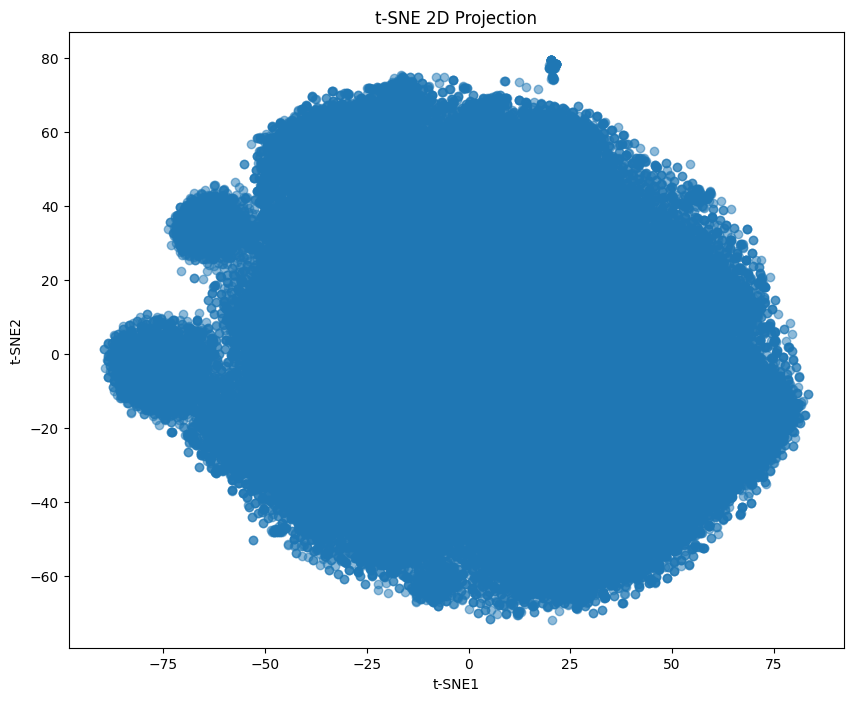

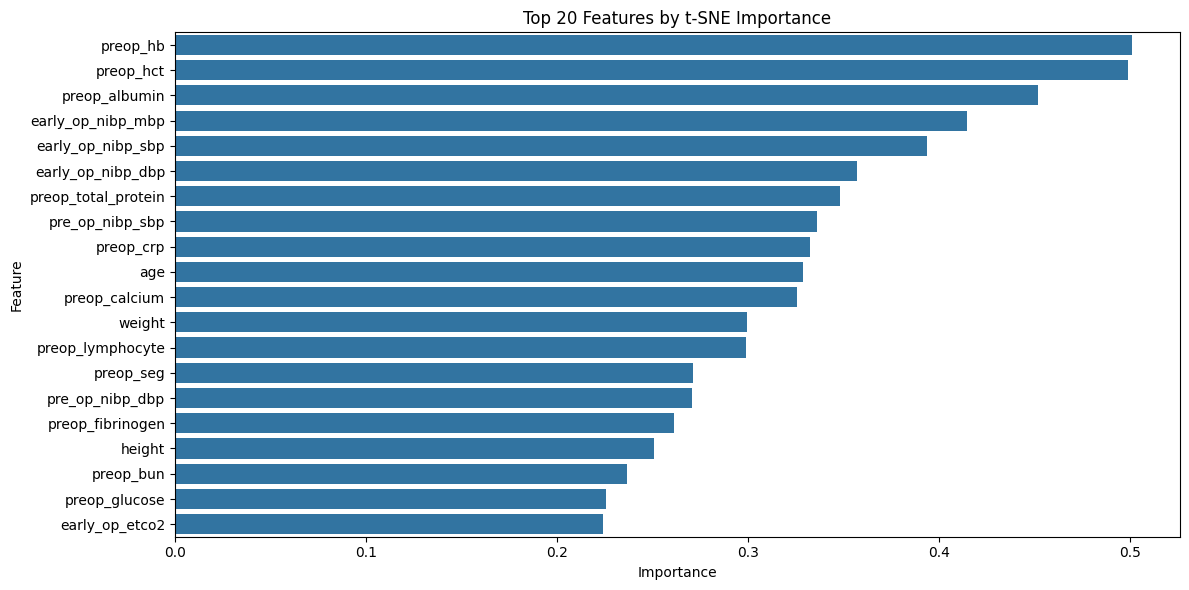


Neighbor Preservation Rate (k=10): 0.1802


In [17]:
#BROKEN - Default barnes_hut algorithim requires max 3 component, can switch to algorithim 'exact' but it is very slow
# Load and standardize the data
df_combined_imputed = pd.read_csv(pca_path.as_posix())
scaler = StandardScaler()
df_combined_imputed = pd.DataFrame(scaler.fit_transform(df_combined_imputed), 
                                 columns=df_combined_imputed.columns)

# Initialize and fit t-SNE
n_components = 2
tsne = TSNE(n_components=n_components, 
            random_state=42,
            method='barnes_hut', #choose between barnes_hut or exact
            perplexity=30,
            n_iter=1000)
tsne_embedding = tsne.fit_transform(df_combined_imputed)

# Calculate feature importance using correlation with t-SNE components
feature_importances = []
for i in range(n_components):
    correlations = [abs(np.corrcoef(df_combined_imputed[feature], tsne_embedding[:, i])[0, 1]) 
                   for feature in df_combined_imputed.columns]
    feature_importances.append(correlations)

# Calculate overall importance scores
importance_scores = np.mean(np.abs(feature_importances), axis=0)
importance_df = pd.DataFrame({
    'Feature': df_combined_imputed.columns,
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

# Display results
print("t-SNE Feature Importance Scores:")
print(importance_df)

# Plot 2D visualization
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], alpha=0.5)
plt.title('t-SNE 2D Projection')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

# Plot top 20 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Features by t-SNE Importance')
plt.tight_layout()
plt.show()

# Calculate neighbor preservation
from sklearn.neighbors import NearestNeighbors
k = 10

nbrs_orig = NearestNeighbors(n_neighbors=k).fit(df_combined_imputed)
distances_orig, indices_orig = nbrs_orig.kneighbors(df_combined_imputed)

nbrs_tsne = NearestNeighbors(n_neighbors=k).fit(tsne_embedding)
distances_tsne, indices_tsne = nbrs_tsne.kneighbors(tsne_embedding)

neighbor_preservation = np.mean([
    len(set(indices_orig[i][1:]).intersection(set(indices_tsne[i][1:]))) / (k-1)
    for i in range(len(df_combined_imputed))
])

print(f"\nNeighbor Preservation Rate (k={k}): {neighbor_preservation:.4f}")

     ICD10_PCS  Frequency  Rank
0        08DJ3       6905     1
1        09Q70       4178     2
2        08R43       3371     3
3        0HBT0       3190     4
4        0GTK0       2982     5
...        ...        ...   ...
2248     08Q93          1  1445
2249     0MBRX          1  1445
2250     0UT10          1  1445
2251     0T140          1  1445
2252     0RSW3          1  1445

[2253 rows x 3 columns]


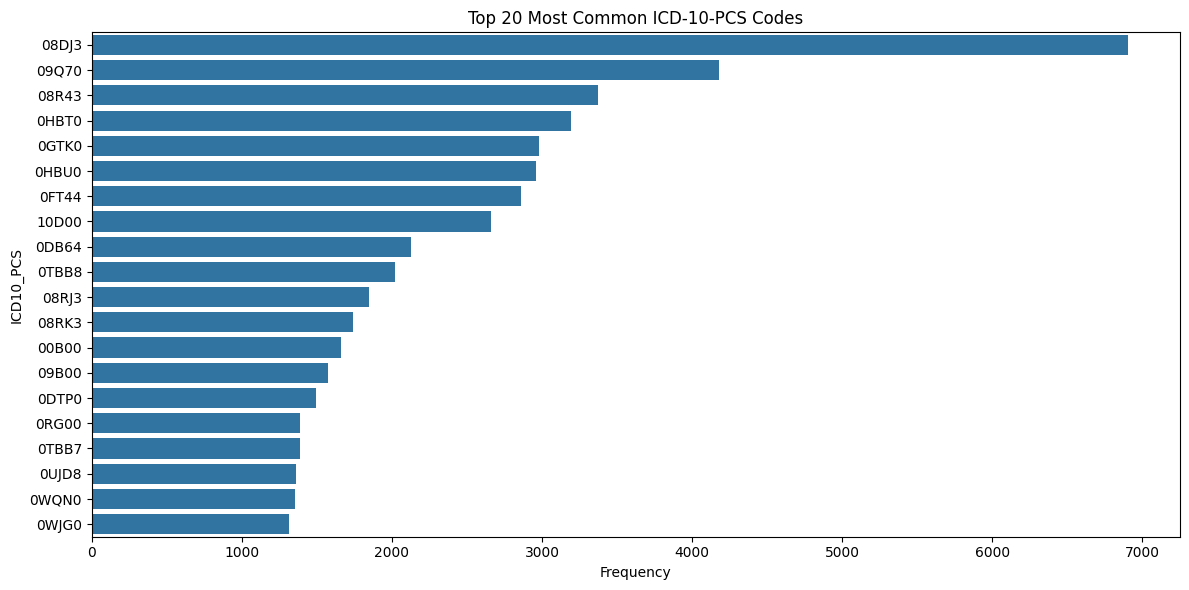


Number of ICD-10-PCS codes with >100 cases: 198


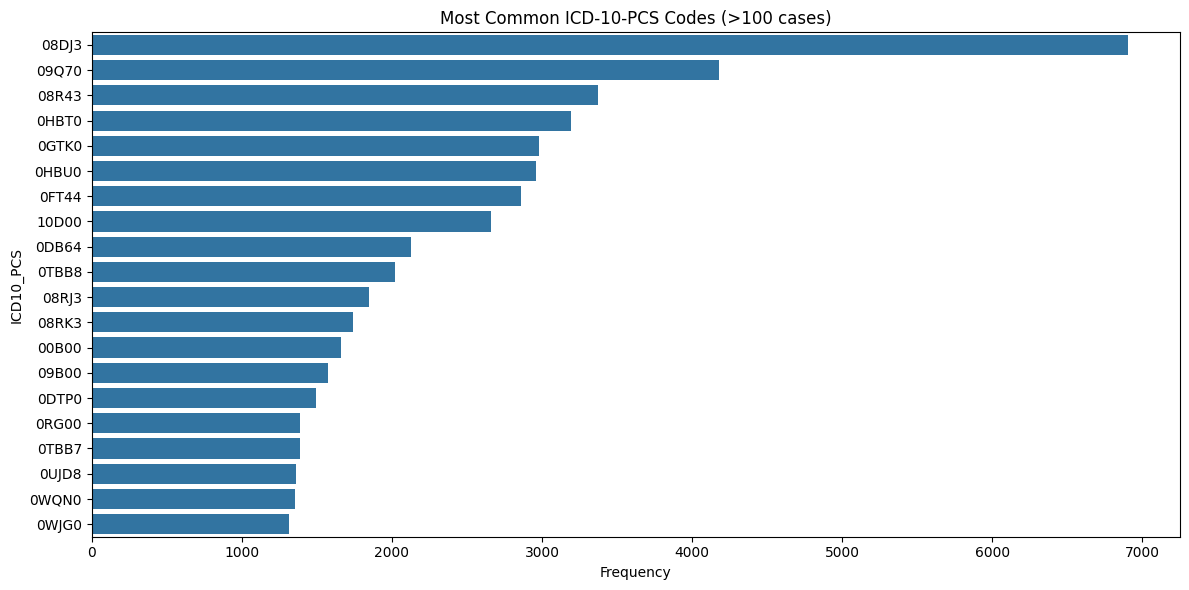

In [4]:
df_operations = pd.read_csv(ops_path.as_posix())

# Count the occurrences of each ICD-10-PCS code and create a ranked DataFrame
icd10_pcs_ranked = df_operations['icd10_pcs'].value_counts().reset_index()
icd10_pcs_ranked.columns = ['ICD10_PCS', 'Frequency']
icd10_pcs_ranked['Rank'] = icd10_pcs_ranked['Frequency'].rank(ascending=False, method='min').astype(int)

# Sort by rank and reset index
icd10_pcs_ranked = icd10_pcs_ranked.sort_values('Rank').reset_index(drop=True)

# Display the full ranked DataFrame
print(icd10_pcs_ranked)

# Plot top 20 for visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=icd10_pcs_ranked.head(20), x='Frequency', y='ICD10_PCS')
plt.title('Top 20 Most Common ICD-10-PCS Codes')
plt.tight_layout()
plt.show()

# Filter for ICD-10-PCS codes with more than 100 occurrences
common_procedures = icd10_pcs_ranked[icd10_pcs_ranked['Frequency'] > 100]

print(f"\nNumber of ICD-10-PCS codes with >100 cases: {len(common_procedures)}")

# Plot common procedures
plt.figure(figsize=(12, 6))
sns.barplot(data=common_procedures.head(20), x='Frequency', y='ICD10_PCS')
plt.title('Most Common ICD-10-PCS Codes (>100 cases)')
plt.tight_layout()
plt.show()

      AnType   Count
0    General  102790
1        MAC   15013
2  Neuraxial   12995
3   Regional     162


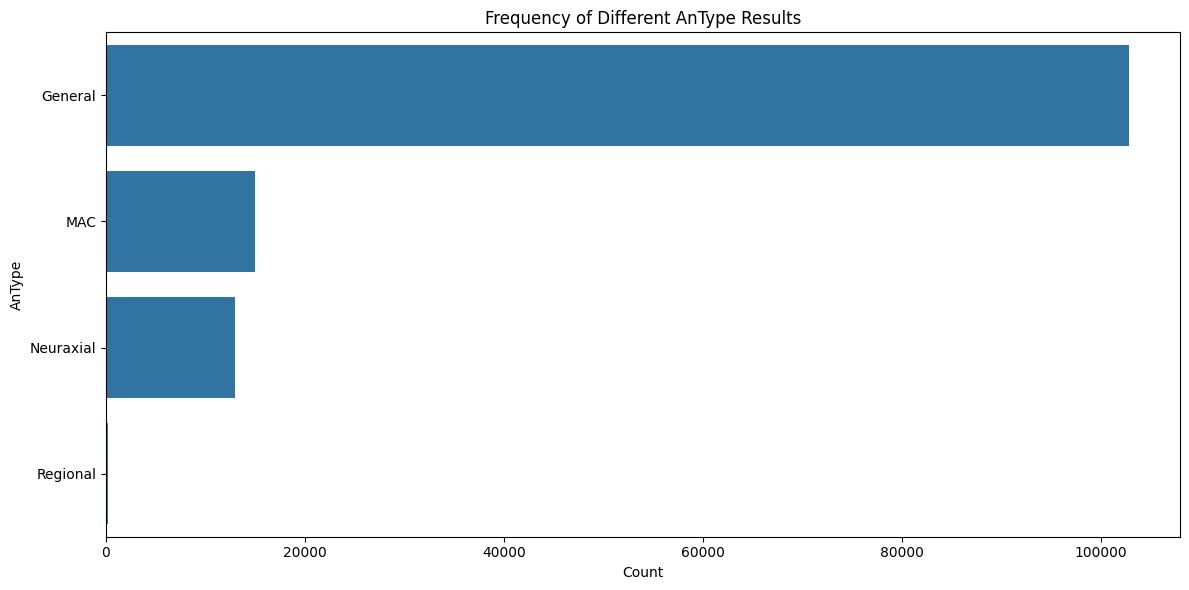

In [ ]:
# Tabulate the frequency of different results in the 'antype' column
antype_counts = df_operations['antype'].value_counts()

# Convert the counts to a DataFrame for better display
antype_counts_df = antype_counts.reset_index()
antype_counts_df.columns = ['AnType', 'Count']

# Display the frequency table
print(antype_counts_df)

# Plot the frequency of different results in the 'antype' column
plt.figure(figsize=(12, 6))
sns.barplot(data=antype_counts_df, x='Count', y='AnType')
plt.title('Frequency of Different AnType Results')
plt.tight_layout()
plt.show()